In [1]:
import numpy as np
from scipy.linalg import dft
import matplotlib.pyplot as plt

In [2]:
M = 64 # symbols per frame
N = 8 # modulation order
number_of_frames = 100
modulation_order = 4 # bits per symbol
snr_db = list(range(-20, 21, 2))
ber = []
# Plot pair list
snr_ber = []
# Channel generation
tau = [0, 1, 2, 3]
mu = [0, 1, 2, 3]

In [3]:
# # Generate 4 random complex numbers with unit amplitude
# phase_angles = np.random.uniform(0, 2 * np.pi, 4)  # Random phases between 0 and 2π
# complex_numbers = (1/np.sqrt(2)) * np.exp(1j * phase_angles)  # Convert to complex form

# # Reshape into a 1x4 numpy array
# h = complex_numbers.reshape(1, 4)
# h = h.flatten()

In [4]:
def qam4_modulate(bits):
    """
    4-QAM modulation: Maps 2-bit pairs to QAM symbols.

    Parameters:
    bits (numpy array): 1D binary array (length should be even)

    Returns:
    numpy array: Complex symbols representing QAM modulation
    """
    if len(bits) % 2 != 0:
        raise ValueError("Input length must be even for 4-QAM modulation.")

    bit_pairs = bits.reshape(-1, 2)  # Reshape into pairs
    symbol_map = {
        (0, 0):  1+1j,  # 00 -> (1,1)
        (0, 1):  1-1j,  # 01 -> (1,-1)
        (1, 0): -1+1j,  # 10 -> (-1,1)
        (1, 1): -1-1j   # 11 -> (-1,-1)
    }
    
    symbols = np.array([symbol_map[tuple(pair)] for pair in bit_pairs])
    return symbols

def qam4_demodulate(symbols):
    """
    4-QAM demodulation: Maps QAM symbols back to binary sequence.

    Parameters:
    symbols (numpy array): Complex-valued matrix received from QAM modulation

    Returns:
    numpy array: 2D binary array (same shape as input but with each element mapped to 2 bits)
    """
    decision_map = {
        1+1j: [0, 0],  # 00
        1-1j: [0, 1],  # 01
        -1+1j: [1, 0],  # 10
        -1-1j: [1, 1]   # 11
    }
    
    # Vectorized processing of each symbol in the input matrix
    demodulated_bits = np.zeros((symbols.shape[0], symbols.shape[1] * 2), dtype=int)
    
    for i in range(symbols.shape[0]):
        for j in range(symbols.shape[1]):
            symbol = symbols[i, j]
            closest_point = min(decision_map.keys(), key=lambda x: abs(x - symbol))
            demodulated_bits[i, 2*j:2*j+2] = decision_map[closest_point]
    
    return demodulated_bits

def generate_complex_gaussian_matrix(rows, cols, sigma):
    """
    Generates a matrix of complex Gaussian random numbers.

    Parameters:
    - rows (int): Number of rows.
    - cols (int): Number of columns.
    - sigma (float): Standard deviation (square root of variance).

    Returns:
    - numpy.ndarray: (rows, cols) matrix of complex Gaussian numbers.
    """
    real_part = np.random.normal(0, sigma / np.sqrt(2), (rows, cols))  # Real part ~ N(0, sigma^2/2)
    imag_part = np.random.normal(0, sigma / np.sqrt(2), (rows, cols))  # Imaginary part ~ N(0, sigma^2/2)

    complex_matrix = real_part + 1j * imag_part
    return complex_matrix

def dft_matrix(N):
    """
    Generates an N x N Discrete Fourier Transform (DFT) matrix.

    Parameters:
    N (int): Size of the DFT matrix.

    Returns:
    numpy.ndarray: N x N DFT matrix.
    """
    n = np.arange(N)
    k = n.reshape((N, 1))
    omega = np.exp(-2j * np.pi * k * n / N)  # DFT formula
    return omega

In [5]:
binary_sequence = np.random.randint(0, 2, size=M*N)

In [ ]:
binary_matrix = binary_sequence.reshape(M, N)
qam4_symbols = qam4_modulate(bits=binary_matrix)
I = np.eye(M)
dft = dft_matrix(N=N//2)
p_Signal = 1
pi = np.roll(np.eye(M * N//2), shift=1)
# Define the diagonal elements
i_values = np.arange(M * N//2)  # i ranges from 0 to 255
diagonal_elements = np.exp(1j * i_values * 2 * np.pi / M)  # e^(i*j*2*pi/64)
# Create a diagonal matrix using np.diag()
delta = np.diag(diagonal_elements)
H = np.matmul(np.roll(pi, shift=0), np.linalg.matrix_power(delta, 0))
# This is the output s(t).

# H = H * h[0]

# Initializing channel:
for j in range(1, N//2):
    # H = np.add(np.matmul(np.roll(pi, j), np.linalg.matrix_power(delta, j)), H * h[j])
    H = np.add(np.matmul(np.roll(pi, j), np.linalg.matrix_power(delta, j)), H)
H_eff = np.matmul(np.matmul(np.kron(dft, I), H), np.kron(np.conj(dft), I))
# Channel initiailization ends

qam4_symbols_reshaped = qam4_symbols.reshape(M * N//2, 1)
for i in snr_db:
    tot_errors = 0
    for epoch in range(0, 100):
        sigma = np.sqrt((10**(-i/10)) * p_Signal)
        complex_gaussian_matrix = generate_complex_gaussian_matrix(M, N//2, sigma)
        complex_gaussian_matrix_reshaped = complex_gaussian_matrix.reshape(M * N//2, 1)
        w_tilde = np.matmul(np.kron(dft, I), complex_gaussian_matrix_reshaped)
        y = (H_eff @ qam4_symbols_reshaped) + w_tilde
        x_cap = np.matmul(np.linalg.inv(H_eff), y)
        x_cap_demodulated = qam4_demodulate(x_cap)
        x_cap_demodulated_reshaped = x_cap_demodulated.reshape(M * N, 1)
        errors:int = 0
        for j in range(len(x_cap_demodulated_reshaped)):
            if (x_cap_demodulated_reshaped[j] != binary_sequence[j]):
                errors += 1
        tot_errors += errors
        print(f"i = {i}, epoch = {epoch}, errors = {errors}")
    average_error = tot_errors/100
    snr_ber.append((i, average_error/(M*N))) 

i = -20, epoch = 0, errors = 223
i = -20, epoch = 1, errors = 245
i = -20, epoch = 2, errors = 246
i = -20, epoch = 3, errors = 243
i = -20, epoch = 4, errors = 252
i = -20, epoch = 5, errors = 244
i = -20, epoch = 6, errors = 238
i = -20, epoch = 7, errors = 251
i = -20, epoch = 8, errors = 257
i = -20, epoch = 9, errors = 244
i = -20, epoch = 10, errors = 240
i = -20, epoch = 11, errors = 243
i = -20, epoch = 12, errors = 233
i = -20, epoch = 13, errors = 239
i = -20, epoch = 14, errors = 236
i = -20, epoch = 15, errors = 256
i = -20, epoch = 16, errors = 255
i = -20, epoch = 17, errors = 250
i = -20, epoch = 18, errors = 233
i = -20, epoch = 19, errors = 235
i = -20, epoch = 20, errors = 249
i = -20, epoch = 21, errors = 229
i = -20, epoch = 22, errors = 241
i = -20, epoch = 23, errors = 250
i = -20, epoch = 24, errors = 252
i = -20, epoch = 25, errors = 241
i = -20, epoch = 26, errors = 244
i = -20, epoch = 27, errors = 242
i = -20, epoch = 28, errors = 239
i = -20, epoch = 29, err

In [7]:
print(snr_ber)

[(-20, 0.4732421875), (-18, 0.4687109375), (-16, 0.46076171875), (-14, 0.4497265625), (-12, 0.4323828125), (-10, 0.4246875), (-8, 0.4081640625), (-6, 0.37931640625), (-4, 0.34552734375), (-2, 0.311875), (0, 0.25916015625), (2, 0.2251171875), (4, 0.167421875), (6, 0.1244140625), (8, 0.0861328125), (10, 0.04392578125), (12, 0.0190234375), (14, 0.01123046875), (16, 0.00447265625), (18, 0.00064453125), (20, 0.0002734375)]


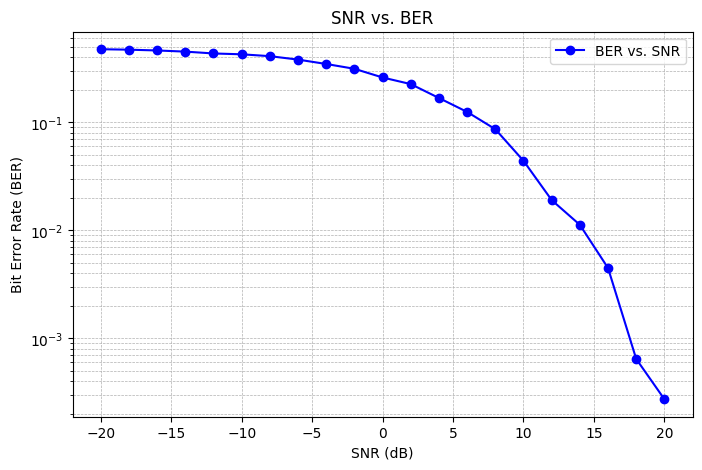

In [8]:
# Extract SNR (x-axis) and BER (y-axis)
snr_values, ber_values = zip(*snr_ber)

# Plot the graph
plt.figure(figsize=(8, 5))
plt.plot(snr_values, ber_values, marker='o', linestyle='-', color='b', label="BER vs. SNR")

# Log scale for BER axis (since BER values are very small)
plt.yscale("log")

# Labels and title
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("SNR vs. BER")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()

# Show the plot
plt.show()

SNR = 0
ifram = 0
ifram = 1
ifram = 2
ifram = 3


/tmp/ipykernel_3635708/4095118148.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
  de_data_cap = np.round((x_cap / np.sqrt(mod_order) + 1) / 2).astype(int)


ifram = 4
ifram = 5
ifram = 6
ifram = 7
ifram = 8
ifram = 9
ifram = 10
ifram = 11
ifram = 12
ifram = 13
ifram = 14
ifram = 15
ifram = 16
ifram = 17
ifram = 18
ifram = 19
ifram = 20
ifram = 21
ifram = 22
ifram = 23
ifram = 24
ifram = 25
ifram = 26
ifram = 27
ifram = 28
ifram = 29
ifram = 30
ifram = 31
ifram = 32
ifram = 33
ifram = 34
ifram = 35
ifram = 36
ifram = 37
ifram = 38
ifram = 39
ifram = 40
ifram = 41
ifram = 42
ifram = 43
ifram = 44
ifram = 45
ifram = 46
ifram = 47
ifram = 48
ifram = 49
ifram = 50
ifram = 51
ifram = 52
ifram = 53
ifram = 54
ifram = 55
ifram = 56
ifram = 57
ifram = 58
ifram = 59
ifram = 60
ifram = 61
ifram = 62
ifram = 63
ifram = 64
ifram = 65
ifram = 66
ifram = 67
ifram = 68
ifram = 69
ifram = 70
ifram = 71
ifram = 72
ifram = 73
ifram = 74
ifram = 75
ifram = 76
ifram = 77
ifram = 78
ifram = 79
ifram = 80
ifram = 81
ifram = 82
ifram = 83
ifram = 84
ifram = 85
ifram = 86
ifram = 87
ifram = 88
ifram = 89
ifram = 90
ifram = 91
ifram = 92
ifram = 93
ifram = 94
ifram

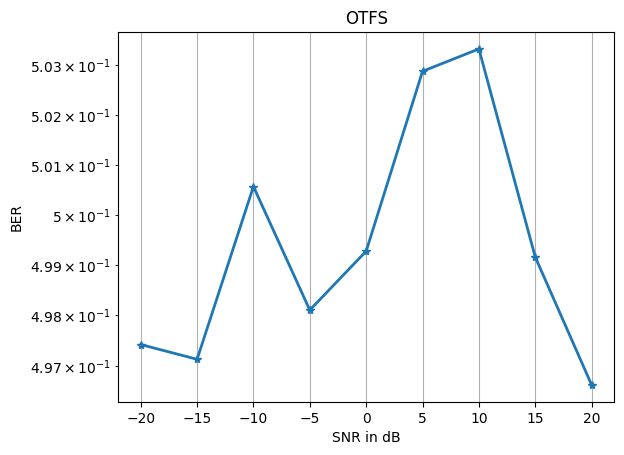

In [2]:
import numpy as np
import matplotlib.pyplot as plt

M = 64  # No.of subcarriers
N = 4  # No.of symbols
N_Frames = 10**2  # Total No. of Frames

mod_order = 4  # Modulation Order
bits_per_symbol = int(np.log2(mod_order))

symbols_per_frame = M * N
bits_per_frame = symbols_per_frame * bits_per_symbol

SNR_dB = np.arange(-20, 21, 5)
SNR = 10 ** (SNR_dB / 10)
noise_var_sqrt = np.sqrt(1. / SNR)

eng_sqrt = (mod_order == 2) + (mod_order != 2) * np.sqrt((mod_order - 1) / 6 * (2 ** 2))
sigma_2 = np.abs(eng_sqrt * noise_var_sqrt) ** 2

np.random.seed(1)
err_ber = np.zeros(len(SNR_dB))
for snr in range(len(SNR_dB)):
    print(f"SNR = {snr}")
    for ifram in range(N_Frames):
        # Information Bits Generation
        print(f"ifram = {ifram}")
        bi_data = np.random.randint(0, 2, bits_per_frame)
        data_mtx = bi_data.reshape(symbols_per_frame, bits_per_symbol)
        de_data = np.packbits(data_mtx, axis=-1)
        x = np.array([np.sqrt(mod_order) * (1 - 2 * bit) for bit in de_data])  # QAM modulation
        X = x.reshape(M, N)

        # OTFS Modulation
        F_M = np.fft.fft(np.eye(M))
        F_N = np.fft.fft(np.eye(N))
        Gtx = np.eye(M)
        Grx = Gtx

        S = Gtx @ X @ F_N.T
        s = S.flatten()

        # Channel Generation
        taps = 4
        Delay_taps = np.arange(taps)
        Doppler_taps = np.arange(taps)
        pow_prof = (1 / taps) * np.ones(taps)
        h = np.sqrt(pow_prof) * (np.sqrt(1 / 2) * (np.random.randn(taps) + 1j * np.random.randn(taps)))

        # Channel Output
        I = np.eye(M * N)
        Pi = np.roll(I, 1, axis=0)
        z = np.exp((1j * 2 * np.pi) / (M * N))
        Del = np.diag(z ** np.arange(M * N))
        H = 0
        for i in range(taps):
            H += h[i] * np.roll(Pi, Delay_taps[i], axis=0) @ (Del ** Doppler_taps[i])
        w = np.sqrt(sigma_2[snr] / 2) * (np.random.randn(M * N) + 1j * np.random.randn(M * N))

        # Receiver Processing
        w_tilda = np.kron(F_N, Grx) @ w
        Heff = np.kron(F_N, Grx) @ H @ np.kron(F_N.T, Gtx)
        y = Heff @ x + w_tilda

        x_cap = np.linalg.pinv(Heff) @ y

        de_data_cap = np.round((x_cap / np.sqrt(mod_order) + 1) / 2).astype(int)
        # Reshape de_data_cap to have the correct number of rows before applying unpackbits
        de_data_cap = de_data_cap.reshape(-1, 1)  # Reshape to a column vector

        # Reshape before viewing as uint8 and unpacking bits
        de_data_cap_uint8 = de_data_cap.reshape(len(de_data_cap),) # Reshape to 1D
        # The line below is changed to get the correct number of bits
        data_mtx_cap = np.unpackbits(de_data_cap_uint8[:len(de_data_cap_uint8)//8].view(np.uint8)) 
        data_mtx_cap = data_mtx_cap.reshape(-1, bits_per_symbol) # Reshape to (-1, bits_per_symbol)
        # Now you can slice as before
        #data_mtx_cap = data_mtx_cap[:, :bits_per_symbol]  
        bi_data_est = data_mtx_cap.flatten()
        # Ensure bi_data_est and bi_data have compatible shapes
        bi_data_est = bi_data_est[:len(bi_data)]  

        error = np.sum(np.bitwise_xor(bi_data_est, bi_data))
        err_ber[snr] += error

err_ber_fram = err_ber / bits_per_frame / N_Frames
plt.semilogy(SNR_dB, err_ber_fram, '-*', linewidth=2)
plt.title('OTFS')
plt.ylabel('BER')
plt.xlabel('SNR in dB')
plt.grid(True)
plt.show()